# Importando bibliotecas

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from numpy.linalg import inv
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

%matplotlib inline

#Carregando e visualizando os dados

In [ ]:
data_train = pd.read_csv('train.csv')
data_train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


# EDA

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [ ]:
data_train['sales'] = data_train['sales'].astype(float)

In [ ]:
data_train.tail()

,date,store,item,sales
912995,2017-12-27,10,50,63.0
912996,2017-12-28,10,50,59.0
912997,2017-12-29,10,50,74.0
912998,2017-12-30,10,50,62.0
912999,2017-12-31,10,50,82.0


In [ ]:
data_train['date'] =  pd.to_datetime(data_train['date'], format='%Y-%m-%d') #transformando em datetime 

In [ ]:
data_train.dtypes

date     datetime64[ns]
store             int64
item              int64
sales           float64
dtype: object

In [ ]:
data_train = data_train.set_index('date') #transformando em DatetimeIndex 
data_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   store   913000 non-null  int64  
 1   item    913000 non-null  int64  
 2   sales   913000 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 27.9 MB


Transformar os dados em Datetime e depois substituir esses valores no índice, é uma boa prática ao trabalhar com Series Temporais, além de que se torna mais fácil a manipulação e seleção dos dados.

In [ ]:
def plotar(title, labelx, labely, x, y, dataset):
  ax = sns.lineplot(x = x, y = y, data = dataset)
  ax.figure.set_size_inches(12,8)
  ax.set_title(title, loc = 'left', fontsize = 18)
  ax.set_xlabel(labelx, fontsize = 14)
  ax.set_ylabel(labely, fontsize = 14);

Criei uma função para plotar gráficos pois será necessário em outras visualizações. Nesse gráfico há uma notória sazonalidade dos dados e aparentemente uma tendência de crescimento com o passar dos anos. 

In [ ]:
new_data = data_train[(data_train.item==1) & 
            (data_train.store==1)].copy() #selecionando loja1 e item1 para analisar mais profundamente
new_data.head()

,store,item,sales
date,,,
2013-01-01,1,1,13.0
2013-01-02,1,1,11.0
2013-01-03,1,1,14.0
2013-01-04,1,1,13.0
2013-01-05,1,1,10.0


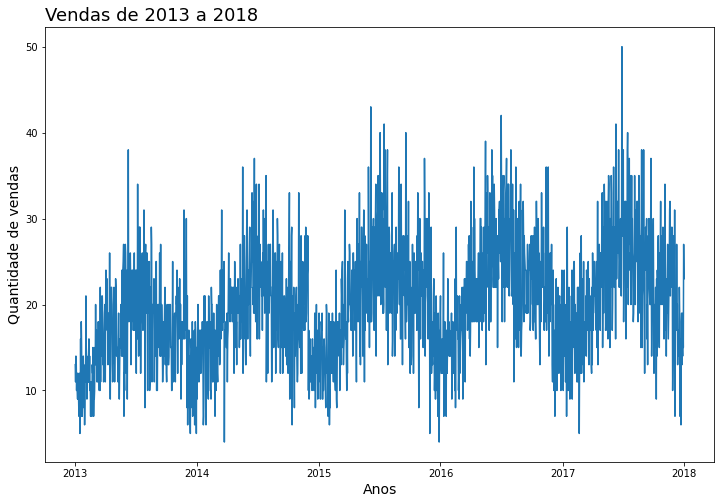

In [ ]:
plotar('Vendas de 2013 a 2018','Anos','Quantidade de vendas',new_data.index,
       'sales',new_data)

In [ ]:
new_data['mes'] = new_data.index.month
new_data['dia'] = new_data.index.day
new_data['dia_do_ano'] = new_data.index.dayofweek
new_data['dia_da_semana'] = new_data.index.weekday

In [ ]:
new_data['increase'] = new_data.sales.diff() #aplicando diff
new_data.head()

,store,item,sales,mes,dia,dia_do_ano,dia_da_semana,increase
date,,,,,,,,
2013-01-01,1,1,13.0,1,1,1,1,NaN
2013-01-02,1,1,11.0,1,2,2,2,-2.0
2013-01-03,1,1,14.0,1,3,3,3,3.0
2013-01-04,1,1,13.0,1,4,4,4,-1.0
2013-01-05,1,1,10.0,1,5,5,5,-3.0


Uma suposição comum em diversos modelos de time series é que os dados sejam estacionários. A variável 'Sales' não parece ter dados estacionários, logo, irei fazer esse processo.

Ao aplicar o método diff() e atribuir a uma coluna, estamos pedindo a máquina para fazer a diferenciação dos dados, ou seja, fazendo a diferença entre o valor atual e o valor anterior da coluna 'Sales'. Normalmente basta fazer uma diferenciação para que os dados se tornem estacionários.

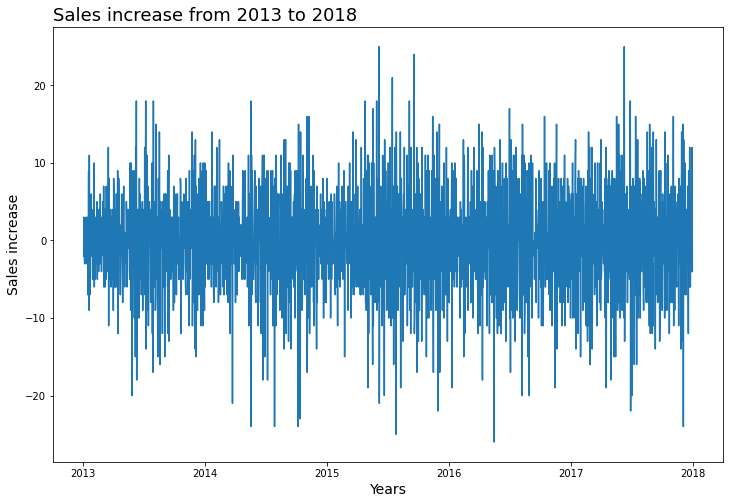

In [ ]:
plotar('Sales increase from 2013 to 2018','Years','Sales increase',
       new_data.index,'increase',new_data)

Visualizando os dados estacionários pode-se perceber que não há mais a tendência e sazonalidade. Há outros pontos a serem observados para uma série ser considerada estacionária, você poder ler mais sobre isso <a> href= '' nesse post<a/>

In [ ]:
new_data['acceleration'] = new_data.increase.diff()
new_data.head()

,store,item,sales,mes,dia,dia_do_ano,dia_da_semana,increase,acceleration
date,,,,,,,,,
2013-01-01,1,1,13.0,1,1,1,1,NaN,NaN
2013-01-02,1,1,11.0,1,2,2,2,-2.0,NaN
2013-01-03,1,1,14.0,1,3,3,3,3.0,5.0
2013-01-04,1,1,13.0,1,4,4,4,-1.0,-4.0
2013-01-05,1,1,10.0,1,5,5,5,-3.0,-2.0


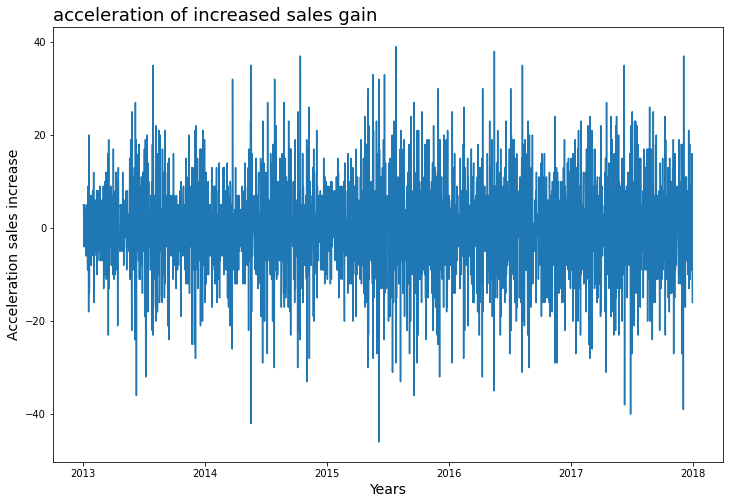

In [ ]:
plotar('acceleration of increased sales gain',
     'Years','Acceleration sales increase',new_data.index,'acceleration',new_data)

In [ ]:
def plot_comparacao(title, x, y1, y2, y3, dataset):
  plt.figure(figsize=(16,12))
  ax = plt.subplot(3,1,1)
  ax.set_title(title, fontsize=18, loc='left')
  ax = sns.lineplot(x=x, y=y1, data=dataset)

  plt.subplot(3,1,2)
  ax = sns.lineplot(x=x, y=y2, data=dataset)

  plt.subplot(3,1,3)
  ax = sns.lineplot(x=x, y=y3, data=dataset);

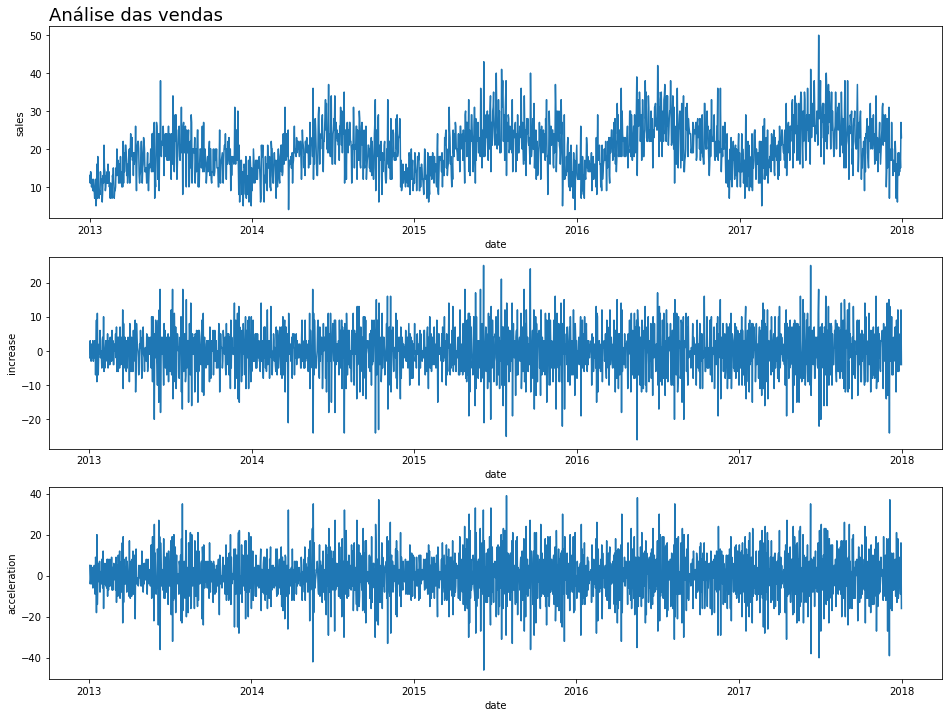

In [ ]:
plot_comparacao('Análise das vendas',new_data.index, 'sales', 'increase',
                'acceleration', new_data)

Comparando os gráficos, pode-se reafirmar que antes não havia estacionariedade nos dados e passou a ter após o tratamento. Além disso, a série mais abaixo não se torna útil devido a grande similariedade entre ela e a série 'increase'.

# Decompondo os dados

Should I use an additive model or a multiplicative model?

Choose the multiplicative model when the magnitude of the seasonal pattern in the data depends on the magnitude of the data. In other words, the magnitude of the seasonal pattern increases as the data values increase, and decreases as the data values decrease. Choose the additive model when the magnitude of the seasonal pattern in the data does not depend on the magnitude of the data. In other words, the magnitude of the seasonal pattern does not change as the series goes up or down. If the pattern in the data is not very obvious, and you have trouble choosing between the additive and multiplicative procedures, you can try both and choose the one with smaller accuracy measures.

<Figure size 432x288 with 0 Axes>

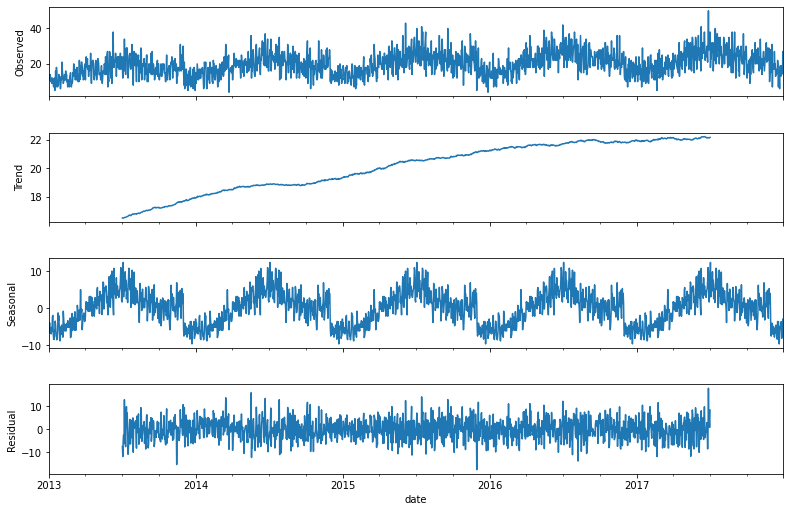

In [ ]:
resultado = seasonal_decompose(new_data.sales, freq=365)
ax = plt.figure()
ax = resultado.plot()
ax.set_size_inches(12,8)

Decompondo os dados, apresentam-se várias informações.

1. Há um gráfico com vários plots e o plot mais acima mostra os dados obervados de fato e os abaixo nós destrinchamos mais informações implícitas.

2. O segundo plot mostra a tendência dos dados, o que nada mais é que o comportamento da série em longo prazo e existe quando há um acréscimo ou descréscimo dos dados no tempo.

3. Na 3° imagem pode-se observar a sazonalidade, que resumidamente, é um padrão repetitivo durante um tempo. Esse padrão pode ser por conta da estação do ano, datas comemorativas ou qualquer outro fator externo que se repita e afete as vendas.

4. No último é apresentado os resíduos ou variações irregulares. Nela é mostrado as variações inexplicadas dos dados, que pode ser de mudança de governo no país, eventos internacionais como a copa do mundo ou diversas outras situações.

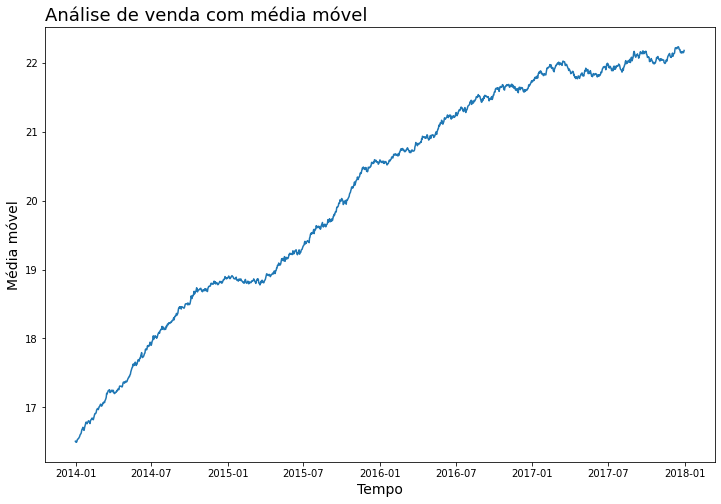

In [ ]:
plotar('Análise de venda com média móvel','Tempo','Média móvel',
     new_data.index, new_data.sales.rolling(365).mean(), new_data)

Apliquei o método rolling() com o parâmetro o '365', utilizei de um número alto para poder ter um gráfico mais suavizado e destacar a tendência. Confirmando a tendência de crescente como já haviamos visto.

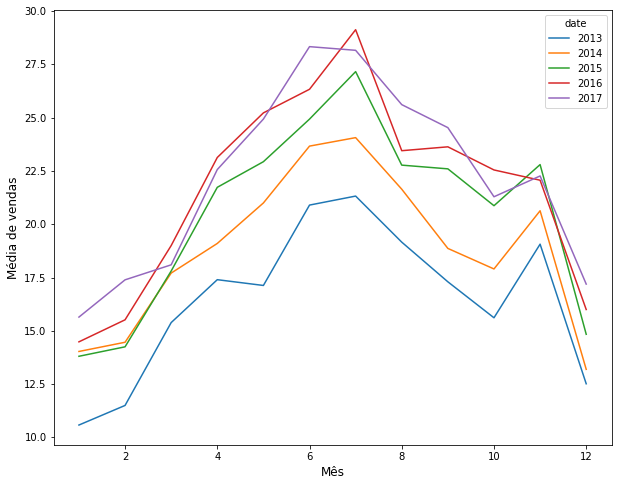

In [ ]:
agrupado = pd.pivot_table(new_data, values='sales', columns=new_data.index.year,
                          index=new_data.index.month)
agrupado.plot(figsize=(10,8));
plt.xlabel('Mês', fontsize=12);
plt.ylabel('Média de vendas', fontsize=12);

Analisando o gráfico pode-se concluir que há uma crescente dos dados no decorrer dos anos até 2016 e em 2017, aparentemente, os dados estão variando mais próximos do ano anterior.

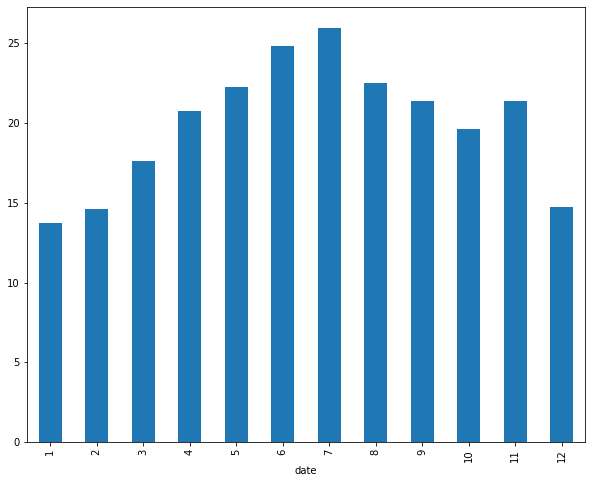

In [ ]:
plt.figure(figsize=(10,8))
grupo = new_data.groupby(new_data.index.month)['sales'].mean()
grupo.plot(kind='bar')


Observando o gráfico acima, podemos reafirmar o comportamento sazonal dos dados, onde a partir de abril há um grande aumento até setembro e novembro também tem um acréscimo.

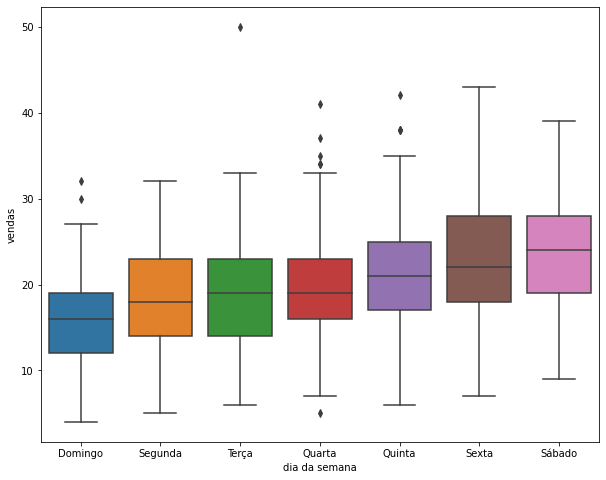

In [ ]:
plt.figure(figsize=(10,8))
ax = sns.boxplot(x=new_data.index.weekday, y="sales", data=new_data)
ax.set(xlabel='dia da semana', ylabel='vendas');
ax.set_xticklabels(['Domingo','Segunda','Terça','Quarta','Quinta','Sexta','Sábado']);

Plotando o gráfico boxplot e dividindo-o por dia da semana. Há uma crescente e alguns Outliers mas nada conclusivo.

In [ ]:
comeco_train = '2013-01-01'
termino_train = '2017-08-31'
comeco_test = '2017-09-01'
termino_test = '2017-12-31'

In [ ]:
sales_train = new_data[comeco_train:termino_train]
sales_test = new_data[comeco_test:termino_test]
sales_train.shape, sales_test.shape

((1704, 9), (122, 9))

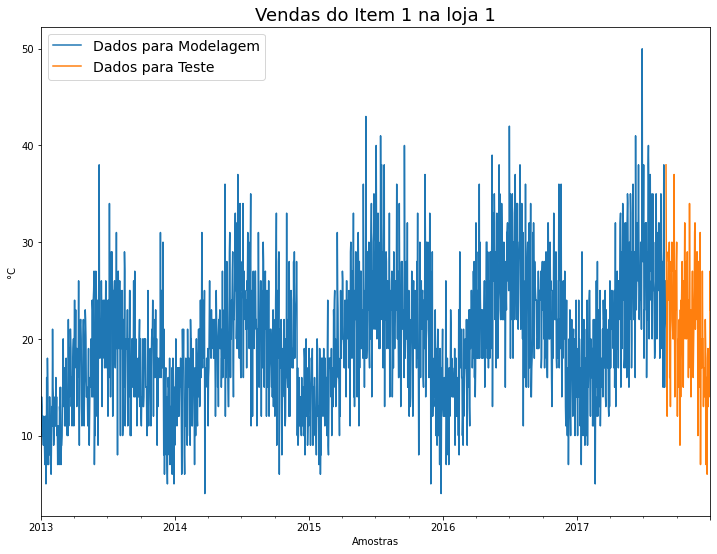

In [ ]:
plt.figure(figsize = (12, 9))

sales_train['sales'].plot()
sales_test['sales'].plot()
legenda = ('Dados para Modelagem', 'Dados para Teste')
plt.legend(legenda, loc = 'upper left', prop = {'size': 14})
plt.title('Vendas do Item 1 na loja 1', fontdict = {'fontsize': 18})
plt.xlabel('Amostras')
plt.ylabel('°C');

In [ ]:
y_train = sales_train['sales']
y_test = sales_test['sales'].dropna()

Irei usar o test dick fuller para verificar a estacionariedade dos dados
onde:
h0: o dado não é estacionário
h1: o dado é estacionário


In [ ]:
resultado = sm.tsa.adfuller(new_data['sales'].dropna())
print('p-value: {}'.format(resultado[1]))

p-value: 0.022569380626570427


Não rejeita-se h0 ao nível de significância de 5%, isto é, o dado não é estacionário




# Definindo funções

In [ ]:
def MQtend(Serie, polOrder, indice):
    N = len(Serie)
    T = np.ones((N, polOrder + 1))
    
    for i in range(polOrder + 1):
        T[:, i] = (indice.T)**i
        
    thetaMQ = np.dot(np.dot(inv(np.dot(T.T, T)), T.T), Serie)
    
    return thetaMQ

def MQestimativa(Parametros, indice):
    N = len(indice)
    polOrder = len(Parametros) - 1
    T = np.ones((N, polOrder + 1))
    
    for i in range(polOrder + 1):
        T[:, i] = (indice.T)**i
        
    Zest = np.dot(T, Parametros)
    
    return Zest

In [ ]:
Zt = new_data['sales'].values
t = np.array([np.arange(1, len(new_data)+1)]).T
nModel = len(new_data) - len(sales_test)

tModel = t[0:nModel]
ZtModel = Zt[0:nModel]

tTeste = t[nModel:]
ZtTeste = Zt[nModel:]

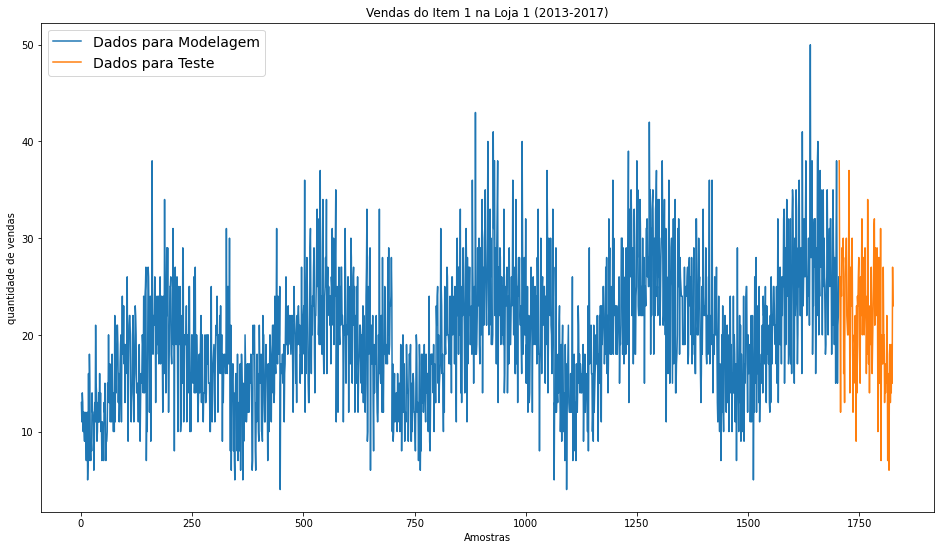

In [ ]:
plt.figure(figsize = (16, 9))

plt.plot(tModel, ZtModel, label = 'Dados para Modelagem')
plt.plot(tTeste, ZtTeste, label = 'Dados para Teste')
plt.legend(loc = 'upper left', prop = {'size': 14})
plt.title('Vendas do Item 1 na Loja 1 (2013-2017)')
plt.xlabel('Amostras')
plt.ylabel('quantidade de vendas');

#Modelagem

In [ ]:
Theta1 = MQtend(ZtModel, 1, tModel)
Theta2 = MQtend(ZtModel, 30, tModel)
Theta3 = MQtend(ZtModel, 90, tModel)
Theta4 = MQtend(ZtModel, 180, tModel)
Theta5 = MQtend(ZtModel, 300, tModel)

print(f'Parâmetros do modelo 1: {Theta1.T}')
print(f'Parâmetros do modelo 2: {Theta2.T}')
print(f'Parâmetros do modelo 3: {Theta3.T}')
print(f'Parâmetros do modelo 4: {Theta4.T}')
print(f'Parâmetros do modelo 5: {Theta5.T}')


Parâmetros do modelo 1: [1.58214301e+01 4.75767422e-03]
Parâmetros do modelo 2: [ 1.11038167e+01  6.35537535e-02 -2.05608835e-04  3.02753531e-07
 -1.98848337e-10  4.76792255e-14  3.47702467e-19 -1.32897827e-20
  4.01169751e-20  4.99436175e-20 -6.97139134e-20 -3.47126467e-20
 -2.91405050e-20  7.22686721e-21 -3.52281405e-20  1.40982704e-20
  4.34892268e-21  2.84138755e-20  1.12968566e-20 -6.41591645e-22
  2.62128730e-20  6.91549264e-22  8.08591196e-21 -5.12940050e-20
  1.16541020e-20 -1.64454046e-20  1.95215698e-21  1.81113851e-20
  1.07978814e-20  4.30215688e-21  1.36858047e-20]
Parâmetros do modelo 3: [ 1.11309989e+01  6.23522526e-02 -2.01329880e-04  2.96610018e-07
 -1.95009515e-10  4.68250337e-14  3.61581405e-19 -1.33159073e-20
  5.15224785e-20  5.67791276e-20 -6.51803835e-20 -3.77364277e-20
 -3.86868681e-20  1.46462942e-20 -3.68826492e-20  2.25116764e-20
  8.14122831e-21  4.17731180e-20  2.42186386e-20 -3.04118886e-21
  2.53200211e-20  7.32296302e-22  1.56968322e-20 -4.97324266e-20
 

In [ ]:
ZtModel1 = MQestimativa(Theta1, tModel)
ZtModel2 = MQestimativa(Theta2, tModel)
ZtModel3 = MQestimativa(Theta3, tModel)
ZtModel4 = MQestimativa(Theta4, tModel)
ZtModel5 = MQestimativa(Theta5, tModel)


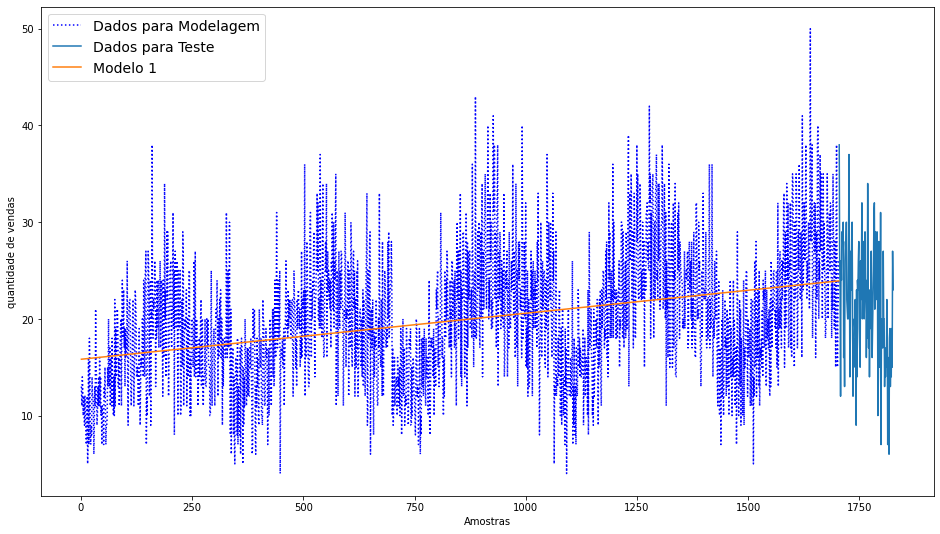

In [ ]:
plt.figure(figsize = (16, 9))

plt.plot(tModel, ZtModel, 'b:', label = 'Dados para Modelagem')
plt.plot(tTeste, ZtTeste, label = 'Dados para Teste')
plt.plot(tModel, ZtModel1, label = 'Modelo 1')
plt.legend(loc = 'upper left', prop = {'size': 14})

plt.xlabel('Amostras')
plt.ylabel('quantidade de vendas');

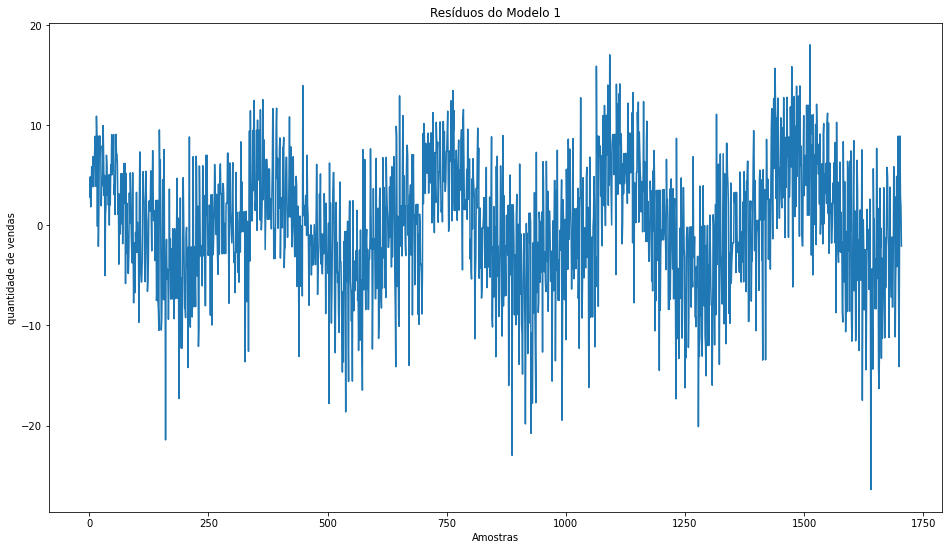

In [ ]:
res1 = ZtModel1 - ZtModel

plt.figure(figsize = (16, 9))
plt.plot(tModel, res1)
plt.title('Resíduos do Modelo 1')

plt.xlabel('Amostras')
plt.ylabel('quantidade de vendas');

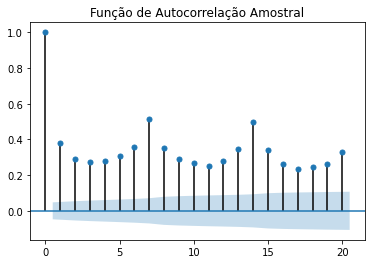

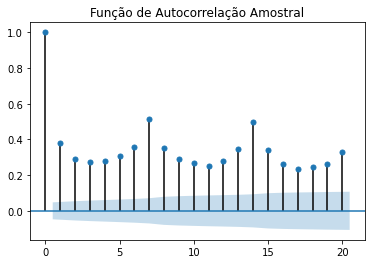

In [ ]:
plot_acf(res1, lags=20, title = 'Função de Autocorrelação Amostral')

In [ ]:
result = adfuller(res1, autolag='AIC')
nSamples = len(res1)

print()
print(f'Número de amostras: {nSamples}')
print(f'   Estatística ADF: {result[0]}')
print(f'           p-valor: {result[1]}')
print(f'    Número de lags: {result[2]}')
print()

for key, value in result[4].items():
    print('Valores Críticos:')
    print(f'   {key}, {value}')
    
print()
print(f'Resultado: A série temporal é {"não " if result[1] > 0.05 else ""}estacionária.')
print()


Número de amostras: 1704
   Estatística ADF: -3.1229050921264316
           p-valor: 0.024903894705897725
    Número de lags: 23

Valores Críticos:
   1%, -3.434248404649074
Valores Críticos:
   5%, -2.8632619252527403
Valores Críticos:
   10%, -2.567686709537982

Resultado: A série temporal é estacionária.



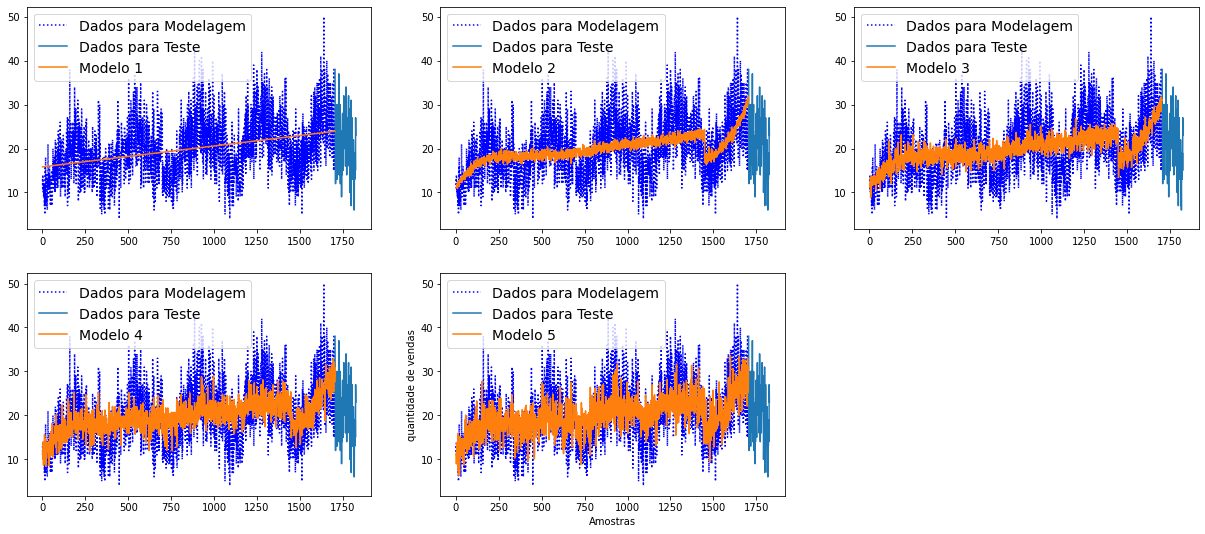

In [ ]:
plt.figure(figsize = (21, 9))

plt.subplot(2,3,1)
plt.plot(tModel, ZtModel, 'b:', label = 'Dados para Modelagem')
plt.plot(tTeste, ZtTeste, label = 'Dados para Teste')
plt.plot(tModel, ZtModel1, label = 'Modelo 1')
plt.legend(loc = 'upper left', prop = {'size': 14})

plt.subplot(2,3,2)
plt.plot(tModel, ZtModel, 'b:', label = 'Dados para Modelagem')
plt.plot(tTeste, ZtTeste, label = 'Dados para Teste')
plt.plot(tModel, ZtModel2, label = 'Modelo 2')
plt.legend(loc = 'upper left', prop = {'size': 14})

plt.subplot(2,3,3)
plt.plot(tModel, ZtModel, 'b:', label = 'Dados para Modelagem')
plt.plot(tTeste, ZtTeste, label = 'Dados para Teste')
plt.plot(tModel, ZtModel3, label = 'Modelo 3')
plt.legend(loc = 'upper left', prop = {'size': 14})

plt.subplot(2,3,4)
plt.plot(tModel, ZtModel, 'b:', label = 'Dados para Modelagem')
plt.plot(tTeste, ZtTeste, label = 'Dados para Teste')
plt.plot(tModel, ZtModel4, label = 'Modelo 4')
plt.legend(loc = 'upper left', prop = {'size': 14})

plt.subplot(2,3,5)
plt.plot(tModel, ZtModel, 'b:', label = 'Dados para Modelagem')
plt.plot(tTeste, ZtTeste, label = 'Dados para Teste')
plt.plot(tModel, ZtModel5, label = 'Modelo 5')
plt.legend(loc = 'upper left', prop = {'size': 14})


plt.xlabel('Amostras')
plt.ylabel('quantidade de vendas');


In [ ]:
res1 = ZtModel1 - ZtModel
res2 = ZtModel2 - ZtModel
res3 = ZtModel3 - ZtModel
res4 = ZtModel4 - ZtModel
res5 = ZtModel5 - ZtModel


In [ ]:
res1Med = np.mean(res1)
res2Med = np.mean(res2)
res3Med = np.mean(res3)
res4Med = np.mean(res4)
res5Med = np.mean(res5)

print(f'Média dos resíduos do modelo 1: {res1Med}')
print(f'Média dos resíduos do modelo 2: {res2Med}')
print(f'Média dos resíduos do modelo 3: {res3Med}')
print(f'Média dos resíduos do modelo 4: {res4Med}')
print(f'Média dos resíduos do modelo 5: {res5Med}')


Média dos resíduos do modelo 1: 2.5352698552942542e-14
Média dos resíduos do modelo 2: -2.233749744380714e-09
Média dos resíduos do modelo 3: -3.779001775042866e-09
Média dos resíduos do modelo 4: -4.2421047582343227e-10
Média dos resíduos do modelo 5: 8.478254134219745e-10


#Teste dos modelos

In [ ]:
ZtTeste1 = MQestimativa(Theta1, tTeste)
ZtTeste2 = MQestimativa(Theta2, tTeste)
ZtTeste3 = MQestimativa(Theta3, tTeste)
ZtTeste4 = MQestimativa(Theta4, tTeste)
ZtTeste5 = MQestimativa(Theta5, tTeste)


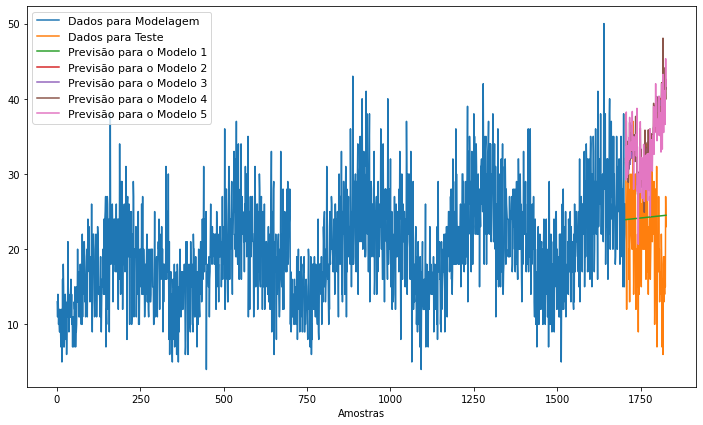

In [ ]:
plt.figure(figsize = (12, 7))

plt.plot(tModel, ZtModel, label = 'Dados para Modelagem')
plt.plot(tTeste, ZtTeste, label = 'Dados para Teste')
plt.plot(tTeste, ZtTeste1, label = 'Previsão para o Modelo 1')
plt.plot(tTeste, ZtTeste2, label = 'Previsão para o Modelo 2')
plt.plot(tTeste, ZtTeste3, label = 'Previsão para o Modelo 3')
plt.plot(tTeste, ZtTeste4, label = 'Previsão para o Modelo 4')
plt.plot(tTeste, ZtTeste5, label = 'Previsão para o Modelo 5')
plt.legend(loc = 'upper left', prop = {'size': 11})
plt.xlabel('Amostras');


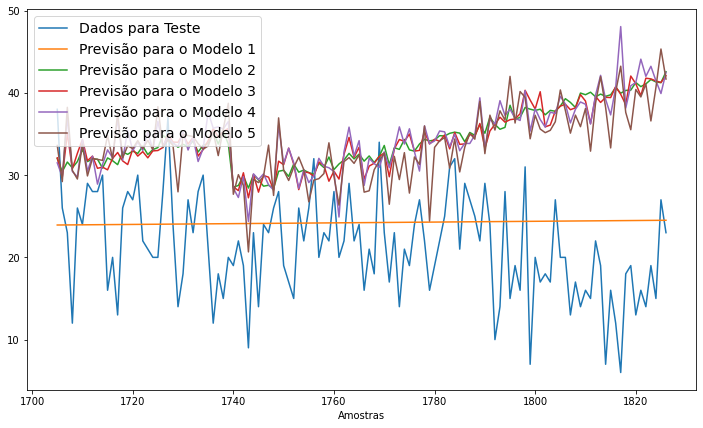

In [ ]:
plt.figure(figsize = (12, 7))

plt.plot(tTeste, ZtTeste, label = 'Dados para Teste')
plt.plot(tTeste, ZtTeste1, label = 'Previsão para o Modelo 1')
plt.plot(tTeste, ZtTeste2, label = 'Previsão para o Modelo 2')
plt.plot(tTeste, ZtTeste3, label = 'Previsão para o Modelo 3')
plt.plot(tTeste, ZtTeste4, label = 'Previsão para o Modelo 4')
plt.plot(tTeste, ZtTeste5, label = 'Previsão para o Modelo 5')
plt.legend(loc = 'upper left', prop = {'size': 14})
plt.xlabel('Amostras');


# Comparação dos modelos e tomada de decisão

In [ ]:
erro1 = (abs(ZtTeste1 - ZtTeste))**2
erro2 = (abs(ZtTeste2 - ZtTeste))**2
erro3 = (abs(ZtTeste3 - ZtTeste))**2
erro4 = (abs(ZtTeste4 - ZtTeste))**2
erro5 = (abs(ZtTeste5 - ZtTeste))**2

erro1Med = np.mean(erro1)
erro2Med = np.mean(erro2)
erro3Med = np.mean(erro3)
erro4Med = np.mean(erro4)
erro5Med = np.mean(erro5)

print(f'Média dos erros do modelo 1: {erro1Med}')
print(f'Média dos erros do modelo 2: {erro2Med}')
print(f'Média dos erros do modelo 3: {erro3Med}')
print(f'Média dos erros do modelo 4: {erro4Med}')
print(f'Média dos erros do modelo 5: {erro5Med}')


Média dos erros do modelo 1: 47.61319921812755
Média dos erros do modelo 2: 236.20581114150758
Média dos erros do modelo 3: 234.1754139840074
Média dos erros do modelo 4: 246.4809165062223
Média dos erros do modelo 5: 218.81541685592188


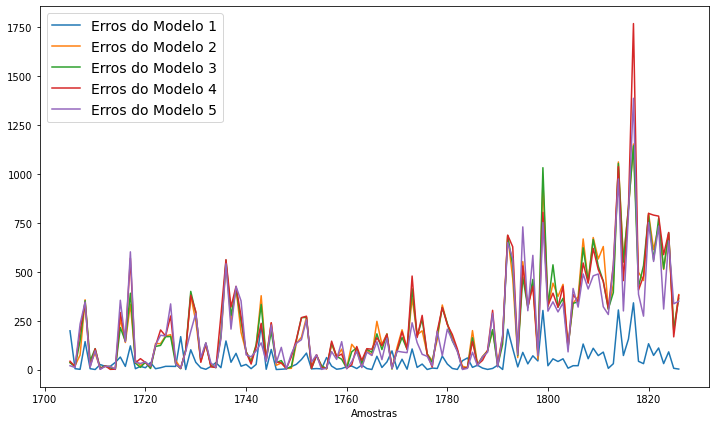

In [ ]:
plt.figure(figsize = (12, 7))

plt.plot(tTeste, erro1, label = 'Erros do Modelo 1')
plt.plot(tTeste, erro2, label = 'Erros do Modelo 2')
plt.plot(tTeste, erro3, label = 'Erros do Modelo 3')
plt.plot(tTeste, erro4, label = 'Erros do Modelo 4')
plt.plot(tTeste, erro5, label = 'Erros do Modelo 5')
plt.legend(loc = 'upper left', prop = {'size': 14})
plt.xlabel('Amostras');

De acordo com a figura acima, pode-se concluir que o modelo que menos erra na previsão dos dados de teste, é o Modelo 1, que é baseado em um modelo polinomial de ordem 1. 

In [ ]:
np.sqrt(mean_squared_error(y_test, ZtTeste1)) #quanto menor esse valor, maior a precisão

6.900231823506189

#Predição com suavização

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
model = ExponentialSmoothing(sales_train.sales, trend='add', seasonal='add',
                             seasonal_periods=365).fit(optimized=True)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [ ]:
test_pred = model.forecast(122)

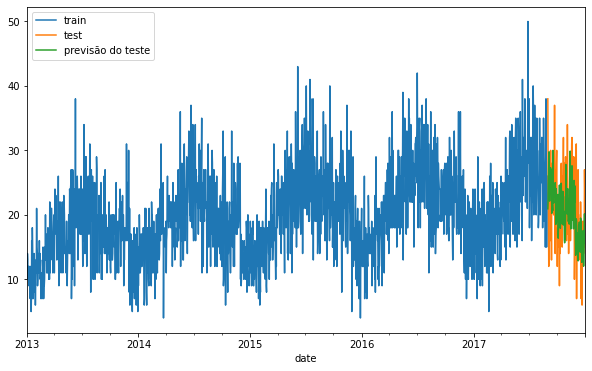

In [ ]:
plt.figure(figsize = (12, 7))

sales_train.sales.plot(legend=True, label='train', figsize=(10,6))
sales_test.sales.plot(legend=True, label='test', figsize=(10,6))
test_pred.plot(legend=True, label='previsão do teste')


In [ ]:
print(model.model.params['smoothing_level'])
print(model.model.params['smoothing_slope'])
print(model.model.params['smoothing_seasonal'])

0.05263157894736842
0.05263157894736842
0.42105263157894735


# Model evaluation

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
np.sqrt(mean_squared_error(y_test, test_pred)) #quanto menor esse valor, maior a precisão

6.340761534435981

#Previsão para dados futuros

In [ ]:
final_model = ExponentialSmoothing(new_data.sales,trend='add',seasonal='add',
                                   seasonal_periods=365).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [ ]:
pred = final_model.forecast(122)

In [ ]:
pred[:5]

2018-01-01    17.299963
2018-01-02    15.214695
2018-01-03    13.747769
2018-01-04    15.310101
2018-01-05    14.719254
Freq: D, dtype: float64

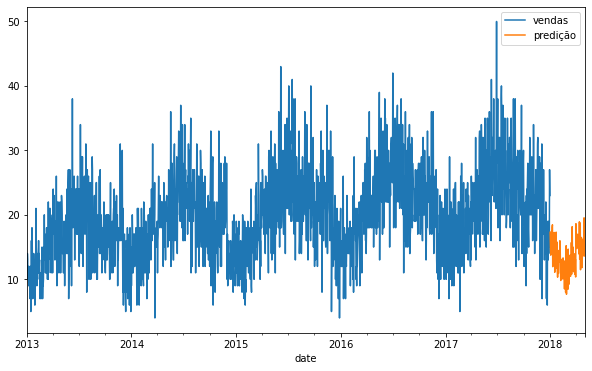

In [ ]:
new_data.sales.plot(legend=True, label='vendas', figsize=(10,6))
pred.plot(legend=True, label='predição')

In [ ]:
np.sqrt(mean_squared_error(y_test, pred))

10.566783642237503

,store,item,sales,mes,dia,dia_do_ano,dia_da_semana,increase,acceleration
date,,,,,,,,,
2017-12-27,1,1,14.0,12,27,2,2,-2.0,-5.0
2017-12-28,1,1,19.0,12,28,3,3,5.0,7.0
2017-12-29,1,1,15.0,12,29,4,4,-4.0,-9.0
2017-12-30,1,1,27.0,12,30,5,5,12.0,16.0
2017-12-31,1,1,23.0,12,31,6,6,-4.0,-16.0


1826